# Notebook Setup

In [15]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Math


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from utilities import jackknife

# Data Reading

In [5]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_p0_q0",
                            operator_folder= "../operator_database",
                            momentum='PX0_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



# Std Analysis

In [7]:
p2corr = opAnalyzer.get_p2corr() #shape = (nconf, latticeT)

latticeT = opAnalyzer.latticeT
nconf = opAnalyzer.nconf

"(nconf, latticeT)"
p2corr.shape

'(nconf, latticeT)'

(212, 48)

In [23]:
mean_normal = np.mean(p2corr, axis=0)
std_normal = np.std(p2corr, axis=0, ddof=1) /np.sqrt(nconf)

mean_jack, std_jack, cov_jack = jackknife(p2corr, lambda x: np.mean(x, axis=0), jack_axis_list=0, binsize=1, time_axis=-1)

In [ ]:
#function that resample the given arrays along the innermost axis (credit: https://stackoverflow.com/a/53236272)
def resamples_last_axis(arr, reps):
    """
    Function used to resample with replacement the innermost axis of the given array (credit: https://stackoverflow.com/a/53236272)
    
    Input:
        - arr: the input array to be resampled (along the innermost axis)
        - reps: the number of resamples that is required
    
    Output:
        - resampled_array: the input arry resampled along the last axis, shape = (reps,) + arr.shape
    """

    n = arr.shape[-1]


    # create an array to shift random indexes as needed
    shift = np.repeat(np.arange(0, arr.size, n), n).reshape(arr.shape)

    # get a flat view of the array
    arrflat = arr.ravel()

    # sample the array by generating random ints and shifting them appropriately
    return np.array([arrflat[np.random.randint(0, n, arr.shape) + shift] 
                     for i in range(reps)])


#function that generates the bootstap resampled of the given array along a specified axis
def bootstrap_resamples(array: np.ndarray, axis:int, Nres:int):
    """
    Function performing the bootstrap resampling (sample with replacement) of the input array along a given axis
    (obtain with minimal modifications to the code given in: https://stackoverflow.com/a/53236272)
    
    Input:
        - array: input array to be resampled
        - axis: the axis over which to perform the resampling with replacement
        - Nres: the number of required resamples
    
    Output:
        - resamples_array: the array with the resamples, shape = (Nres,) + array.shape
    """

    #we read the number of dimensions of the input array
    ndim = array.ndim

    #input control on the axis parameter
    if axis >= ndim or axis<-ndim:
        raise ValueError(f"The input array has shape {array.shape}, so axis can take values in the range {-ndim}, ..., {ndim}, extremes included, but axis={axis} were given.")
    
    #cast axis to a postive number in the correct range
    axis = (axis + array.ndim) % array.ndim

    #we swap the array as to have the axis to resample on the last axis
    swapped_array = np.swapaxes(array,axis1=axis, axis2=-1)

    #we resample along the last axis
    resamples_array = resamples_last_axis(swapped_array,Nres)

    #we swap again the input axis with the last one (with the +1 taking into account now there is also the resample dimension)
    return np.swapaxes(resamples_array, axis1=axis+1, axis2=-1)

In [ ]:
#function that generates the bootstap resampled of the given array along a specified axis
def bootstrap(array: np.ndarray, axis:int, Nres:int):
    """
    Function performing the bootstrap resampling (sample with replacement) of the input array along a given axis
    (obtain with minimal modifications to the code given in: https://stackoverflow.com/a/53236272)
    
    Input:
        - array: input array to be resampled
        - axis: the axis over which to perform the resampling with replacement
        - Nres: the number of required resamples
    
    Output:
        - resamples_array: the array with the resamples, shape = (Nres,) + array.shape
    """

    #we read the number of dimensions of the input array
    ndim = array.ndim

    #input control on the axis parameter
    if axis >= ndim or axis<-ndim:
        raise ValueError(f"The input array has shape {array.shape}, so axis can take values in the range {-ndim}, ..., {ndim}, extremes included, but axis={axis} were given.")
    
    #cast axis to a postive number in the correct range
    axis = (axis + array.ndim) %array.ndim

    #we swap the array as to have the axis to resample on the last axis
    swapped_array = np.swapaxes(array,axis1=axis, axis2=-1)

    #we resample along the last axis
    resamples_array = resamples_last_axis(swapped_array,Nres)

    #we swap again the input axis with the last one (with the +1 taking into account now there is also the resample dimension)
    return np.swapaxes(resamples_array, axis1=axis+1, axis2=-1)

In [157]:
Nres=150

p2corr_res = bootstrap_resamples(p2corr, axis=0,Nres=Nres)

"(Nres, Nconf, latticeT)"
p2corr_res.shape

'(Nres, Nconf, latticeT)'

(150, 212, 48)

In [158]:
std_bst = np.std( np.mean(p2corr_res,axis=1), axis=0, ddof=1)

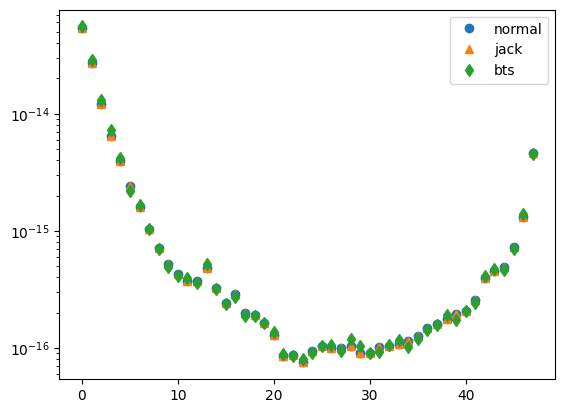

In [159]:
_ = plt.plot(np.arange(latticeT), std_normal, 'o',label="normal")

_ = plt.plot(np.arange(latticeT), std_jack, '^', label="jack")

_ = plt.plot(np.arange(latticeT), std_bst, 'd', label="bts")

_ = plt.legend()

plt.yscale("log")

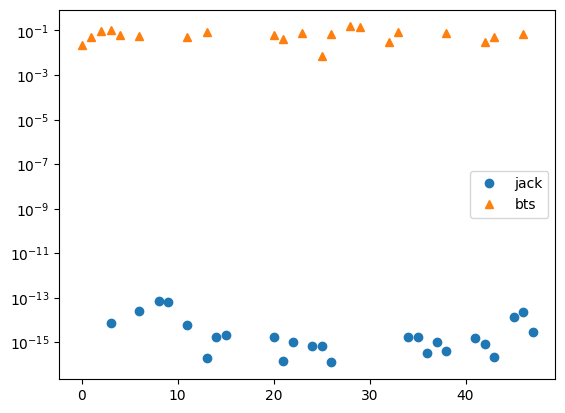

In [160]:
_ = plt.plot(np.arange(latticeT), (std_jack-std_normal)/std_normal, 'o',label="jack")

_ = plt.plot(np.arange(latticeT), (std_bst-std_normal)/std_normal, '^',label="bts")

_ = plt.legend()


plt.yscale("log")